In [19]:
import numpy as np
from scipy import integrate, interpolate
from threeML import *
import matplotlib.pyplot as plt

from Positronium_Spectrum import *
from DM_2gamma import *

In [20]:
#########################################
# Import NFW residuals and response files
#########################################
nfw = fits.open('NFW_spectrum.fits.gz')
resp = resp = fits.open('spectral_response.rmf.fits.gz')
Emin = resp[3].data['E_MIN']
Emax = resp[3].data['E_MAX']
E = np.sqrt(Emin*Emax)
df = nfw[2].data['DFLUX']
df_err = nfw[2].data['DFLUX_ERR']

# data file
ig_file = "total_spectrum.fits.gz"
ig_data_set = OGIPLike("ig_data",
                   observation=ig_file,
                   response="spectral_response.rmf.fits.gz",)
ig_data_set.set_active_measurements('c0-c24')

In [25]:
#######################################
# Perform 1D all spectral component fit
#######################################

# Dark matter mass range to evaluate
Mass_arr = np.logspace(np.log10(61),np.log10(16000),50)

# Get UB on decay rate for each dark matter mass
Gamma_UB = np.zeros(len(Mass_arr))
for i in range(len(Mass_arr)):
    Mass = int(Mass_arr[i])
    
    # Initial values for the spectra
    ig_spectrum = Cutoff_powerlaw(K=1e-5,piv=50,index=0,xc=7.) + \
                    Powerlaw(K=1e-5,piv=1000,index=-1.3) + \
                    Gaussian(F=1e-3,mu=1809,sigma=1.7) + \
                    Positronium_Spectrum(Flux=1.7e-3,f_Ps=1.0) + \
                    DM_2gamma(mass=Mass)
    ig_source = PointSource("ig", l=0, b=0, spectral_shape=ig_spectrum)
    ig_model = Model(ig_source)
    ig_data = DataList(ig_data_set)

    # Fixed parameters
    ig_model.ig.spectrum.main.composite.index_1.fix = True
    ig_model.ig.spectrum.main.composite.mu_3.fix = True
    ig_model.ig.spectrum.main.composite.sigma_3.fix = True
    ig_model.ig.spectrum.main.composite.mass_5.fix = True

    # setting the priors
    # CVs
    ig_model.ig.spectrum.main.composite.K_1.prior = Log_uniform_prior(lower_bound=1e-5, upper_bound=1e0)
    ig_model.ig.spectrum.main.composite.xc_1.prior = Truncated_gaussian(F=1,mu=7,sigma=3,lower_bound=1,upper_bound=100)
    # power-law continuum (~ICS)
    ig_model.ig.spectrum.main.composite.K_2.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e0)
    ig_model.ig.spectrum.main.composite.index_2.prior = Uniform_prior(lower_bound=-3,upper_bound=0)
    # 26Al line flux
    ig_model.ig.spectrum.main.composite.F_3.prior = Log_uniform_prior(lower_bound=1e-10, upper_bound=1e0)
    # positron annihilation
    ig_model.ig.spectrum.main.composite.Flux_4.prior = Log_uniform_prior(lower_bound=1e-6, upper_bound=1e-1)
    ig_model.ig.spectrum.main.composite.f_Ps_4.prior = Truncated_gaussian(F=1,mu=1,sigma=0.2,lower_bound=0,upper_bound=1)
    # dark matter
    ig_model.ig.spectrum.main.composite.Norm_5.prior = Log_uniform_prior(lower_bound=1e-8, upper_bound=1e-1)

    # Bayesian fit
    ig_bs = BayesianAnalysis(ig_model, ig_data)
    ig_bs.set_sampler("emcee")
    ig_bs.sampler.setup(n_iterations=2000,n_burn_in=5000,n_walkers=20)
    ig_samples = ig_bs.sample(quiet=False)
    ig_bs_samples = ig_bs.results.samples
    
    # Save results
    ar = ig_bs.results
    ar.write_to('Results/DM_2gamma_%s.fits'%(Mass), overwrite = True)

    # Get UB on flux normalization at 95% CL
    alpha = 0.05
    K_ub_M = np.percentile(ig_bs_samples[7],100*(1-alpha))

    # Get UB on decay rate at 95% CL
    E_ind = np.where(Mass/2<=Emax)[0][0]
    E_int = np.linspace(Emin[E_ind],Emax[E_ind],num=2000)
    x = E_int
    # eq. 1 (2209.06299)
    Dfactor = 1.289e29 # keV/cm2
    sigma_Eresol = 0.5 # keV
    A = 2. / (4. * np.pi * Mass) / (np.sqrt(2 * np.pi) * sigma_Eresol) * np.exp(-(x - (Mass / 2.)) ** 2 / (2. * sigma_Eresol ** 2))   * Dfactor
    A_int = integrate.simps(A, x=E_int)
    Gamma = K_ub_M / A_int 
    Gamma_UB[i] = Gamma
    
#     # Plot the samples
#     plt.plot(ig_bs_samples[7],'o',markersize=0.3)
#     plt.xlabel(r'Samples')
#     plt.ylabel(r'log10(Normalization)')
#     plt.yscale('log')
#     plt.show()
#     print('Upper limit = ',Gamma )

    # Save UB
    np.savetxt('Results/DM_2gamma_%s.txt'%(Mass), np.array([Mass, K_ub_M, Gamma]))

    

[WARNING ] Found TSTOP and TELAPSE. This file is invalid. Using TSTOP.
[WARNING ] FILTER is not set. This is not a compliant OGIP file. Assuming no FILTER.
[WARNING ] The response is in an extension called MATRIX, which usually means you also need an ancillary file (ARF) which you didn't provide. You should refer to the documentation  of the instrument and make sure you don't need an ARF.
[INFO    ] Auto-probed noise models:
[INFO    ] - observation: gaussian
[INFO    ] - background: None
[INFO    ] Range c0-c24 translates to channels 0-24
[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.229225
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.1 -1.9 +2.5) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.5 -2.8 +2.7              keV
ig.spectrum.main.composite.K_2        (7.5 +/- 0.7) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.29 +/- 0.05                 
ig.spectrum.main.composite.F_3        (3.9 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.34 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.9 +/- 0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5         (9 -7 +8) x 10^-4  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        10.314565
total          10.314565


Values of statistical measures:



statistical measures
AIC               4.970870
BIC               4.795301
DIC             -43.514014
PDIC            -32.835434

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.228125
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.5 -2.1 +2.8) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               6.7 -2.5 +2.4              keV
ig.spectrum.main.composite.K_2        (7.5 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.29 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.35 +/- 0.15) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.1 +/- 0.7) x 10^-1                 
ig.spectrum.main.composite.Norm_5         (9 -8 +9) x 10^-4  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.578542
total          12.578542


Values of statistical measures:



statistical measures
AIC               0.442917
BIC               0.267347
DIC             -13.053245
PDIC             -1.848064

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.24874999999999997
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.4 -2.0 +2.8) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.0 -2.2 +2.6   
ig.spectrum.main.composite.K_2           (7.4 +/- 0.7) x 10^-6   
ig.spectrum.main.composite.index_2              -1.29 +/- 0.06   
ig.spectrum.main.composite.F_3         (4.0 -0.7 +0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.35 -0.18 +0.17) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (9.0 -0.9 +0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5            (8 -7 +8) x 10^-4   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data         12.48367
total           12.48367


Values of statistical measures:



statistical measures
AIC               0.632660
BIC               0.457090
DIC             -20.102610
PDIC             -9.318507

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.24447500000000005
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.7 -2.1 +2.2) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.7 -1.7 +1.9              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3      (4.1 -0.7 +0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.33 +/- 0.16) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.9 +/- 0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (2.3 -2.0 +2.1) x 10^-4  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.413445
total          12.413445


Values of statistical measures:



statistical measures
AIC               0.773110
BIC               0.597541
DIC             -62.198678
PDIC            -49.692919

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.25120000000000003
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.1 -2.2 +2.5) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.4 -1.5 +1.4              keV
ig.spectrum.main.composite.K_2        (7.4 +/- 0.5) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.37 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.1 +/- 0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (1.9 -1.7 +1.9) x 10^-4  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        11.841383
total          11.841383


Values of statistical measures:



statistical measures
AIC               1.917233
BIC               1.741664
DIC             -51.077055
PDIC            -37.801792

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2632
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1        (2.5 +/- 1.7) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.5 -1.3 +1.6              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3      (4.0 -0.7 +0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.32 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (9.0 -0.7 +0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5         (9 -8 +9) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.643924
total          12.643924


Values of statistical measures:



statistical measures
AIC               0.312151
BIC               0.136582
DIC             -25.303815
PDIC            -11.876674

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.21927499999999997
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.2 -2.5 +3.5) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.6 +/- 1.8              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.34 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.9 +/- 0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5         (9 -8 +9) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.098016
total          12.098016


Values of statistical measures:



statistical measures
AIC               1.403969
BIC               1.228400
DIC             -85.712954
PDIC            -72.843845

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.21662499999999998
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (3.5 -2.8 +3.3) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.5 -1.7 +1.9   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.26 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.34 -0.14 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (9.0 -0.9 +0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5            (4 +/- 4) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.777271
total          12.777271


Values of statistical measures:



statistical measures
AIC               0.045458
BIC              -0.130112
DIC             -92.856103
PDIC            -79.378799

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.241325
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1        (3.5 -2.5 +4) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.2 -1.4 +1.5              keV
ig.spectrum.main.composite.K_2        (7.2 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.07                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.5) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.38 +/- 0.16) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.1 +/- 0.7) x 10^-1                 
ig.spectrum.main.composite.Norm_5         (4 +/- 4) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        11.759213
total          11.759213


Values of statistical measures:



statistical measures
AIC               2.081573
BIC               1.906004
DIC             -43.952762
PDIC            -30.404049

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.227475
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.0 -2.3 +2.8) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.7 -1.8 +1.7              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.32 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.9 +/- 0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (3.4 -3.1 +3.2) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.125816
total          12.125816


Values of statistical measures:



statistical measures
AIC               1.348368
BIC               1.172799
DIC             -79.063978
PDIC            -65.299553

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.24622499999999997
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.4 -1.7 +2.3) x 10^-1   
ig.spectrum.main.composite.xc_1                    7.8 +/- 1.6   
ig.spectrum.main.composite.K_2           (7.2 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.37 -0.17 +0.18) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (9.0 -0.9 +0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5      (2.7 -2.5 +2.9) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.082673
total          12.082673


Values of statistical measures:



statistical measures
AIC               1.434653
BIC               1.259084
DIC             -44.098402
PDIC            -30.130021

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.25229999999999997
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.7 -1.8 +2.1) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.6 -1.4 +1.3   
ig.spectrum.main.composite.K_2         (7.4 -0.7 +0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.33 -0.17 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (8.9 +/- 0.9) x 10^-1   
ig.spectrum.main.composite.Norm_5      (2.4 -2.3 +2.6) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data         13.01084
total           13.01084


Values of statistical measures:



statistical measures
AIC              -0.421680
BIC              -0.597250
DIC             -39.172156
PDIC            -25.151014

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.25692499999999996
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.8 -1.9 +2.4) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.6 -1.5 +1.4              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.34 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.9 +/- 0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (2.8 +/- 2.5) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.784789
total          12.784789


Values of statistical measures:



statistical measures
AIC               0.030423
BIC              -0.145147
DIC             -44.211678
PDIC            -30.554982

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2572
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (3.2 -2.2 +2.8) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.2 -1.3 +1.2   
ig.spectrum.main.composite.K_2         (7.4 -0.7 +0.6) x 10^-6   
ig.spectrum.main.composite.index_2           -1.28 -0.06 +0.07   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.5) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.34 -0.17 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (8.8 -1.1 +1.0) x 10^-1   
ig.spectrum.main.composite.Norm_5        (1.8 +/- 1.7) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.555411
total          12.555411


Values of statistical measures:



statistical measures
AIC               0.489177
BIC               0.313608
DIC             -30.896212
PDIC            -16.251499

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.22467500000000004
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.6 -2.0 +2.5) x 10^-1   
ig.spectrum.main.composite.xc_1                  8.0 -1.9 +1.7   
ig.spectrum.main.composite.K_2           (7.4 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.34 -0.15 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (8.8 -0.9 +1.0) x 10^-1   
ig.spectrum.main.composite.Norm_5      (1.1 -1.0 +1.1) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.889491
total          13.889491


Values of statistical measures:



statistical measures
AIC              -2.178982
BIC              -2.354551
DIC             -98.000006
PDIC            -83.506065

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.243075
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.9 -2.1 +2.7) x 10^-1   
ig.spectrum.main.composite.xc_1                    7.5 +/- 1.5   
ig.spectrum.main.composite.K_2           (7.4 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2           -1.27 -0.06 +0.05   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.34 -0.17 +0.18) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (9.0 -0.9 +0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5      (1.1 -1.0 +1.1) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.649328
total          12.649328


Values of statistical measures:



statistical measures
AIC               0.301345
BIC               0.125775
DIC             -45.917275
PDIC            -31.332196

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.26080000000000003
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.6 -1.9 +2.0) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.6 -1.4 +1.6   
ig.spectrum.main.composite.K_2           (7.4 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.31 -0.18 +0.17) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (9.0 -0.9 +0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5        (1.1 +/- 1.0) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.465697
total          13.465697


Values of statistical measures:



statistical measures
AIC              -1.331394
BIC              -1.506963
DIC             -38.625669
PDIC            -24.089308

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.21197500000000002
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.8 -2.2 +3.1) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               8.0 -2.1 +1.9              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.33 +/- 0.16) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (9.2 -0.5 +0.6) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.9 +/- 1.8) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data         12.48224
total           12.48224


Values of statistical measures:



statistical measures
AIC               0.635521
BIC               0.459951
DIC            -129.902766
PDIC           -114.988411

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.231325
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.2 -1.6 +1.8) x 10^-1   
ig.spectrum.main.composite.xc_1                  8.3 -1.9 +1.8   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.26 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.33 -0.17 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (8.9 -0.8 +0.9) x 10^-1   
ig.spectrum.main.composite.Norm_5        (2.2 +/- 1.9) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.337355
total          13.337355


Values of statistical measures:



statistical measures
AIC              -1.074711
BIC              -1.250280
DIC             -79.714186
PDIC            -65.508523

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.25034999999999996
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.8 -2.0 +2.4) x 10^-1   
ig.spectrum.main.composite.xc_1                    7.6 +/- 1.6   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.7) x 10^-6   
ig.spectrum.main.composite.index_2           -1.27 -0.06 +0.07   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.32 -0.15 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (8.7 -1.2 +1.1) x 10^-1   
ig.spectrum.main.composite.Norm_5      (1.2 -1.0 +1.1) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.542376
total          12.542376


Values of statistical measures:



statistical measures
AIC               0.515248
BIC               0.339679
DIC             -49.782585
PDIC            -34.963853

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.25549999999999995
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.4 -2.4 +3.3) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.1 +/- 1.4              keV
ig.spectrum.main.composite.K_2        (7.4 +/- 0.7) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.05                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.36 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.7 +/- 1.1) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.2 +/- 1.0) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.692891
total          12.692891


Values of statistical measures:



statistical measures
AIC               0.214218
BIC               0.038649
DIC             -36.914148
PDIC            -22.257168

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.253125
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.9 -2.1 +2.6) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.5 -1.5 +1.6   
ig.spectrum.main.composite.K_2         (7.3 -0.6 +0.7) x 10^-6   
ig.spectrum.main.composite.index_2              -1.26 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.34 -0.19 +0.18) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (8.6 +/- 1.2) x 10^-1   
ig.spectrum.main.composite.Norm_5        (1.1 +/- 0.9) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.974008
total          12.974008


Values of statistical measures:



statistical measures
AIC              -0.348015
BIC              -0.523585
DIC             -44.251116
PDIC            -28.896984

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2481
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.1 -1.5 +1.6) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               8.3 -1.8 +1.9              keV
ig.spectrum.main.composite.K_2      (7.2 -0.7 +0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.26 +/- 0.07                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.34 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (8.8 -1.1 +1.0) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.3 +/- 1.0) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.750506
total          13.750506


Values of statistical measures:



statistical measures
AIC              -1.901012
BIC              -2.076581
DIC             -60.676378
PDIC            -45.310574

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2508
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.6 -2.0 +2.4) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.8 +/- 1.8              keV
ig.spectrum.main.composite.K_2        (7.4 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.29 +/- 0.16) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.3 +/- 1.4) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.4 +/- 1.1) x 10^-5  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data          12.1353
total            12.1353


Values of statistical measures:



statistical measures
AIC               1.329400
BIC               1.153830
DIC             -64.430727
PDIC            -49.161939

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.28049999999999997
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.6 -1.8 +1.9) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.6 -1.4 +1.5   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.28 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.29 -0.17 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (8.2 +/- 1.5) x 10^-1   
ig.spectrum.main.composite.Norm_5      (1.5 -1.1 +1.0) x 10^-5   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.454631
total          12.454631


Values of statistical measures:



statistical measures
AIC               0.690738
BIC               0.515169
DIC             -35.562737
PDIC            -20.621119

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.28862499999999996
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (1.9 -1.2 +1.3) x 10^-1   
ig.spectrum.main.composite.xc_1                    7.9 +/- 1.3   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.7) x 10^-6   
ig.spectrum.main.composite.index_2              -1.26 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.35 -0.19 +0.18) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (9.0 -0.9 +0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5      (2.5 -2.1 +2.2) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.881042
total          12.881042


Values of statistical measures:



statistical measures
AIC              -0.162083
BIC              -0.337652
DIC             -22.477837
PDIC             -6.146851

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.26084999999999997
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.3 -1.5 +1.8) x 10^-1   
ig.spectrum.main.composite.xc_1                    7.8 +/- 1.5   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.7) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.33 -0.18 +0.15) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (9.0 +/- 0.9) x 10^-1   
ig.spectrum.main.composite.Norm_5      (2.4 -2.1 +2.3) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.388153
total          13.388153


Values of statistical measures:



statistical measures
AIC              -1.176306
BIC              -1.351875
DIC             -38.747421
PDIC            -22.426650

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.24137500000000003
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (3.6 -2.7 +3.2) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.2 -1.5 +1.6   
ig.spectrum.main.composite.K_2           (7.2 +/- 0.7) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.07   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.35 -0.17 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (9.0 +/- 0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5      (2.4 -2.1 +2.2) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.299365
total          12.299365


Values of statistical measures:



statistical measures
AIC               1.001270
BIC               0.825701
DIC             -53.684383
PDIC            -37.570177

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.23510000000000003
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (3.2 -2.5 +3.4) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.5 -1.7 +1.9   
ig.spectrum.main.composite.K_2           (7.2 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.5) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.36 -0.17 +0.18) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (9.1 -0.6 +0.7) x 10^-1   
ig.spectrum.main.composite.Norm_5      (3.4 -2.9 +2.7) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.874366
total          12.874366


Values of statistical measures:



statistical measures
AIC              -0.148731
BIC              -0.324301
DIC             -75.284108
PDIC            -58.719554

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.260175
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1           (1.9 +/- 1.3) x 10^-1   
ig.spectrum.main.composite.xc_1                  8.3 -1.6 +1.7   
ig.spectrum.main.composite.K_2           (7.1 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2           -1.27 -0.06 +0.07   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.35 -0.17 +0.18) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (9.0 +/- 0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5            (4 +/- 4) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.448515
total          13.448515


Values of statistical measures:



statistical measures
AIC              -1.297031
BIC              -1.472600
DIC             -41.503063
PDIC            -24.857505

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.27354999999999996
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (1.9 -1.3 +1.4) x 10^-1   
ig.spectrum.main.composite.xc_1                  8.0 -1.4 +1.5   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.27 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.34 -0.16 +0.15) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (8.9 -1.0 +0.9) x 10^-1   
ig.spectrum.main.composite.Norm_5      (1.4 -1.2 +1.4) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data         13.28976
total           13.28976


Values of statistical measures:



statistical measures
AIC              -0.979519
BIC              -1.155088
DIC             -28.941947
PDIC            -12.105191

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.23442500000000002
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.5 -1.9 +2.2) x 10^-1   
ig.spectrum.main.composite.xc_1                  8.0 -1.8 +1.9   
ig.spectrum.main.composite.K_2         (7.3 -0.7 +0.6) x 10^-6   
ig.spectrum.main.composite.index_2           -1.27 -0.05 +0.06   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.32 -0.19 +0.18) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (9.1 +/- 0.7) x 10^-1   
ig.spectrum.main.composite.Norm_5        (1.2 +/- 1.1) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.485169
total          13.485169


Values of statistical measures:



statistical measures
AIC              -1.370337
BIC              -1.545907
DIC             -77.199246
PDIC            -60.356511

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.263725
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.4 -2.4 +2.9) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.2 +/- 1.4              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.7) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.33 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (8.9 -1.0 +0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (4.0 -2.9 +2.7) x 10^-6  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.685536
total          12.685536


Values of statistical measures:



statistical measures
AIC               0.228928
BIC               0.053359
DIC             -42.025766
PDIC            -24.510630

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.27152499999999996
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1        (2.0 +/- 1.4) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 8.1 +/- 1.6              keV
ig.spectrum.main.composite.K_2        (7.2 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.33 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.0 +/- 0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (4.3 -3.2 +3.0) x 10^-6  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.832725
total          12.832725


Values of statistical measures:



statistical measures
AIC              -0.065451
BIC              -0.241020
DIC             -47.961798
PDIC            -29.854148

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.252375
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.0 -2.1 +2.5) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.5 +/- 1.5              keV
ig.spectrum.main.composite.K_2        (7.1 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.31 +/- 0.16) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (9.0 -0.9 +0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.4 +/- 1.2) x 10^-6  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.492393
total          13.492393


Values of statistical measures:



statistical measures
AIC              -1.384786
BIC              -1.560355
DIC             -52.223332
PDIC            -34.650459

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2473
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.0 -2.2 +2.8) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.5 +/- 1.5              keV
ig.spectrum.main.composite.K_2        (7.2 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.36 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.2 +/- 0.7) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.6 +/- 1.3) x 10^-6  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data          13.0217
total            13.0217


Values of statistical measures:



statistical measures
AIC              -0.443401
BIC              -0.618970
DIC             -56.894132
PDIC            -39.343781

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.22685
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.9 -2.3 +3.5) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.8 -1.9 +2.1   
ig.spectrum.main.composite.K_2         (7.3 -0.6 +0.7) x 10^-6   
ig.spectrum.main.composite.index_2              -1.28 +/- 0.06   
ig.spectrum.main.composite.F_3           (3.8 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.36 -0.18 +0.17) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (9.0 +/- 0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5      (2.1 -1.8 +1.7) x 10^-6   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.956131
total          12.956131


Values of statistical measures:



statistical measures
AIC              -0.312262
BIC              -0.487831
DIC             -94.813308
PDIC            -77.435080

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.24064999999999998
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.9 -2.2 +2.7) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.6 -1.6 +1.8              keV
ig.spectrum.main.composite.K_2        (7.2 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.35 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (9.0 -0.9 +0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.1 +/- 0.9) x 10^-6  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.387202
total          13.387202


Values of statistical measures:



statistical measures
AIC              -1.174404
BIC              -1.349974
DIC             -64.931836
PDIC            -47.518027

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.26885
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.7 -1.8 +1.9) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.5 -1.3 +1.4              keV
ig.spectrum.main.composite.K_2      (7.3 -0.6 +0.7) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.33 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (8.9 -1.0 +0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5        (10 -8 +9) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        12.938647
total          12.938647


Values of statistical measures:



statistical measures
AIC              -0.277294
BIC              -0.452863
DIC             -35.319665
PDIC            -17.944656

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.24459999999999998
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.9 -2.1 +2.7) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.6 +/- 1.6              keV
ig.spectrum.main.composite.K_2      (7.2 -0.7 +0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.29 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.5) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.31 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.9 +/- 0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5         (5 -4 +5) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data         13.17683
total           13.17683


Values of statistical measures:



statistical measures
AIC              -0.753661
BIC              -0.929230
DIC             -61.774401
PDIC            -44.308539

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.27017499999999994
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (3.3 -2.2 +2.7) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.1 -1.2 +1.3   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.7) x 10^-6   
ig.spectrum.main.composite.index_2           -1.29 -0.06 +0.05   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.37 -0.18 +0.17) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (9.0 +/- 0.8) x 10^-1   
ig.spectrum.main.composite.Norm_5            (5 -4 +5) x 10^-7   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.391706
total          13.391706


Values of statistical measures:



statistical measures
AIC              -1.183412
BIC              -1.358981
DIC             -33.358187
PDIC            -15.686612

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2559
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.9 -2.0 +2.3) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.5 -1.5 +1.4              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.27 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.31 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4   (8.8 -1.2 +1.0) x 10^-1                 
ig.spectrum.main.composite.Norm_5         (5 +/- 4) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.531661
total          13.531661


Values of statistical measures:



statistical measures
AIC              -1.463322
BIC              -1.638891
DIC             -47.170476
PDIC            -29.690222

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.23345000000000002
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.1 -2.3 +3.1) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1                 7.5 +/- 1.7              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.7) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.35 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.2 +/- 0.7) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (1.3 -1.1 +1.2) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.583357
total          13.583357


Values of statistical measures:



statistical measures
AIC              -1.566713
BIC              -1.742283
DIC             -69.136489
PDIC            -50.823319

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2807
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.0 -1.3 +1.4) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.9 -1.3 +1.4              keV
ig.spectrum.main.composite.K_2      (7.3 -0.7 +0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.33 +/- 0.17) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.0 +/- 0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5     (1.4 +/- 1.1) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data         13.73108
total           13.73108


Values of statistical measures:



statistical measures
AIC              -1.862161
BIC              -2.037730
DIC             -28.528138
PDIC            -10.424166

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.234275
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.7 -2.1 +2.5) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.8 -1.8 +2.0              keV
ig.spectrum.main.composite.K_2        (7.3 +/- 0.7) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.29 +/- 0.07                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.32 +/- 0.16) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.9 +/- 0.9) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (1.1 -0.9 +1.0) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.628654
total          13.628654


Values of statistical measures:



statistical measures
AIC              -1.657307
BIC              -1.832876
DIC             -77.592594
PDIC            -59.866345

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.22292499999999998
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.6 -2.1 +2.6) x 10^-1   
ig.spectrum.main.composite.xc_1                  8.0 -2.0 +2.4   
ig.spectrum.main.composite.K_2           (7.4 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.28 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.0 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.32 -0.17 +0.16) x 10^-3   
ig.spectrum.main.composite.f_Ps_4        (9.0 +/- 0.9) x 10^-1   
ig.spectrum.main.composite.Norm_5           (10 -7 +8) x 10^-8   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.374225
total          13.374225


Values of statistical measures:



statistical measures
AIC              -1.148450
BIC              -1.324020
DIC             -99.413302
PDIC            -81.145472

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.255475
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.3 -1.7 +1.6) x 10^-1   
ig.spectrum.main.composite.xc_1                  7.8 -1.5 +1.7   
ig.spectrum.main.composite.K_2           (7.4 +/- 0.7) x 10^-6   
ig.spectrum.main.composite.index_2              -1.29 +/- 0.05   
ig.spectrum.main.composite.F_3         (4.1 -0.5 +0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.34 -0.18 +0.17) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (8.9 -1.0 +0.9) x 10^-1   
ig.spectrum.main.composite.Norm_5           (10 -8 +9) x 10^-8   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.443849
total          13.443849


Values of statistical measures:



statistical measures
AIC              -1.287697
BIC              -1.463266
DIC             -44.958129
PDIC            -26.433995

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.23257500000000003
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (2.2 -1.8 +2.2) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               8.3 -2.1 +2.3              keV
ig.spectrum.main.composite.K_2        (7.2 +/- 0.7) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.28 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.1 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.32 +/- 0.16) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (8.7 +/- 1.1) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (2.0 -1.6 +1.7) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.469009
total          13.469009


Values of statistical measures:



statistical measures
AIC              -1.338017
BIC              -1.513587
DIC            -105.823332
PDIC            -87.624800

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.23092499999999996
Maximum a posteriori probability (MAP) point:



result  \
parameter                                                        
ig.spectrum.main.composite.K_1         (2.8 -2.2 +2.8) x 10^-1   
ig.spectrum.main.composite.xc_1                    7.8 +/- 1.8   
ig.spectrum.main.composite.K_2           (7.3 +/- 0.6) x 10^-6   
ig.spectrum.main.composite.index_2              -1.29 +/- 0.06   
ig.spectrum.main.composite.F_3           (4.1 +/- 0.6) x 10^-4   
ig.spectrum.main.composite.Flux_4   (1.36 -0.18 +0.19) x 10^-3   
ig.spectrum.main.composite.f_Ps_4      (8.8 -0.9 +1.0) x 10^-1   
ig.spectrum.main.composite.Norm_5      (2.5 -2.0 +2.1) x 10^-7   

                                               unit  
parameter                                            
ig.spectrum.main.composite.K_1      1 / (cm2 keV s)  
ig.spectrum.main.composite.xc_1                 keV  
ig.spectrum.main.composite.K_2      1 / (cm2 keV s)  
ig.spectrum.main.composite.index_2                   
ig.spectrum.main.composite.F_3          1 / (cm2 s)  
ig.spectrum.main.composite.Flux_4       1 / (cm2 s)  
ig.spectrum.main.composite.f_Ps_4                    
ig.spectrum.main.composite.Norm_5   1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.233485
total          13.233485


Values of statistical measures:



statistical measures
AIC              -0.866971
BIC              -1.042540
DIC             -83.730042
PDIC            -65.873899

[INFO    ] sampler set to emcee



[INFO    ] Mean acceptance fraction: 0.2506
Maximum a posteriori probability (MAP) point:



result             unit
parameter                                                                   
ig.spectrum.main.composite.K_1      (3.4 -2.4 +3.3) x 10^-1  1 / (cm2 keV s)
ig.spectrum.main.composite.xc_1               7.4 -1.6 +1.1              keV
ig.spectrum.main.composite.K_2        (7.2 +/- 0.6) x 10^-6  1 / (cm2 keV s)
ig.spectrum.main.composite.index_2           -1.30 +/- 0.06                 
ig.spectrum.main.composite.F_3        (4.0 +/- 0.6) x 10^-4      1 / (cm2 s)
ig.spectrum.main.composite.Flux_4   (1.36 +/- 0.18) x 10^-3      1 / (cm2 s)
ig.spectrum.main.composite.f_Ps_4     (9.0 +/- 0.8) x 10^-1                 
ig.spectrum.main.composite.Norm_5   (2.5 -1.8 +1.7) x 10^-7  1 / (cm2 keV s)


Values of -log(posterior) at the minimum:



-log(posterior)
ig_data        13.393744
total          13.393744


Values of statistical measures:



statistical measures
AIC              -1.187489
BIC              -1.363058
DIC             -68.850319
PDIC            -51.073887

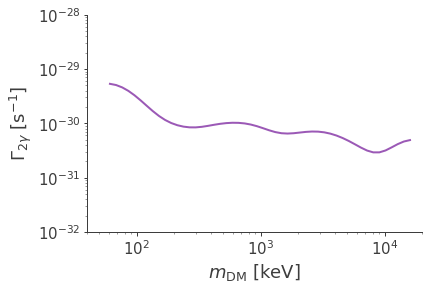

In [27]:
####################################
# Plot 95% upper bound on decay rate
####################################

from scipy.ndimage import gaussian_filter1d as smooth
plt.loglog(Mass_arr,smooth(Gamma_UB,3))

plt.xlabel(r'$m_{\rm DM}$ [keV]',fontsize=18)
plt.ylabel(r'$\Gamma_{2\gamma}$ [s$^{-1}$]',fontsize=18)

plt.xlim(4e1, 2e4)
plt.ylim(1e-32, 1e-28)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()